# Localized Entropy Notebook

This notebook runs the end-to-end pipeline using the config in `configs/default.json`.
Switch between synthetic and CTR data, tune the model, and toggle plots from the config file.


In [1]:
%matplotlib inline
import numpy as np
import torch

from localized_entropy.config import load_and_resolve, loss_label, get_condition_label, get_data_source
from localized_entropy.utils import init_device, set_seed
from localized_entropy.data.pipeline import prepare_data
from localized_entropy.models import ConditionProbNet
from localized_entropy.training import train_with_epoch_plots, evaluate, predict_probs
from localized_entropy.analysis import (
    print_pred_summary,
    collect_le_stats_per_condition,
    collect_logits,
    bce_log_loss,
    roc_auc_score,
    pr_auc_score,
    expected_calibration_error,
    per_condition_metrics,
)
from localized_entropy.plotting import (
    plot_training_distributions,
    plot_eval_log10p_hist,
    plot_loss_curves,
    plot_eval_predictions_by_condition,
    plot_le_stats_per_condition,
    plot_ctr_filter_stats,
    plot_feature_distributions_by_condition,
    plot_label_rates_by_condition,
)

np.set_printoptions(precision=4, suppress=True)
torch.set_printoptions(precision=4)

CONFIG_PATH = "configs/default.json"
cfg = load_and_resolve(CONFIG_PATH)
print(f"Using experiment: {cfg['experiment'].get('name', cfg['experiment'].get('active', 'unknown'))}")

device, use_cuda, non_blocking = init_device()
set_seed(cfg['project']['seed'], use_cuda)

def print_pred_stats_by_condition(
    preds: np.ndarray,
    conds: np.ndarray,
    num_conditions: int,
    *,
    name: str = 'Eval',
) -> None:
    p = np.asarray(preds, dtype=np.float64).reshape(-1)
    c = np.asarray(conds, dtype=np.int64).reshape(-1)
    counts = np.bincount(c, minlength=int(num_conditions))
    print(f"{name} prediction stats per condition:")
    for cond in range(int(num_conditions)):
        n = int(counts[cond])
        if n == 0:
            print(f"  cond {cond}: n=0")
            continue
        pc = p[c == cond]
        print(
            f"  cond {cond}: n={n} min={pc.min():.6g} max={pc.max():.6g} "
            f"mean={pc.mean():.6g}"
        )


Using experiment: baseline
CUDA not available, defaulting to CPU.


In [2]:
# Create reusable top-N filtered datasets + per-condition stats (if enabled).
from pathlib import Path

import pandas as pd

filter_col = cfg["ctr"].get("filter_col")
label_col = cfg["ctr"].get("label_col", "click")
filter_top_k = cfg.get("ctr", {}).get("filter_top_k")
filter_top_k = int(filter_top_k) if filter_top_k is not None else None
if filter_top_k is not None and filter_top_k <= 0:
    filter_top_k = None
read_rows = cfg.get("ctr", {}).get("read_rows")
read_rows = int(read_rows) if read_rows else None

train_path = Path(cfg["ctr"]["train_path"])
test_path = Path(cfg["ctr"]["test_path"])

if filter_col and filter_top_k:
    ad_id_freq_txt = Path("results/ad_id_impressions.txt")
    ad_id_freq_csv = Path("results/ad_id_impressions.csv")
    filtered_train_path = Path(f"data/train_top_{filter_top_k}.csv")
    filtered_test_path = Path(f"data/test_top_{filter_top_k}.csv")

    if ad_id_freq_txt.exists():
        freq_df = pd.read_csv(
            ad_id_freq_txt,
            sep=r"\s+",
            header=None,
            names=["impressions", filter_col],
        )
        freq_df = freq_df.sort_values("impressions", ascending=False).reset_index(drop=True)
    else:
        counts = pd.Series(dtype="int64")
        for chunk in pd.read_csv(
            train_path,
            usecols=[filter_col],
            chunksize=1_000_000,
            nrows=read_rows,
        ):
            counts = counts.add(chunk[filter_col].value_counts(), fill_value=0)
        freq_df = (
            counts.astype(int)
            .sort_values(ascending=False)
            .rename("impressions")
            .reset_index()
            .rename(columns={"index": filter_col})
        )

    ad_id_freq_csv.parent.mkdir(parents=True, exist_ok=True)
    freq_df.to_csv(ad_id_freq_csv, index=False)

    top_ids = freq_df.head(filter_top_k)[filter_col].tolist()
    print(f"Top {filter_top_k} {filter_col} values by impressions: {top_ids}")

    def filter_to_ids(input_path: Path, output_path: Path, ids: list) -> int:
        output_path.parent.mkdir(parents=True, exist_ok=True)
        wrote = False
        row_count = 0
        for chunk in pd.read_csv(input_path, chunksize=1_000_000, nrows=read_rows):
            filtered = chunk[chunk[filter_col].isin(ids)]
            if filtered.empty:
                continue
            row_count += len(filtered)
            filtered.to_csv(
                output_path,
                mode="w" if not wrote else "a",
                header=not wrote,
                index=False,
            )
            wrote = True
        if not wrote:
            pd.read_csv(input_path, nrows=0).to_csv(output_path, index=False)
        return row_count

    train_rows = filter_to_ids(train_path, filtered_train_path, top_ids)
    test_rows = filter_to_ids(test_path, filtered_test_path, top_ids)
    print(f"Filtered train rows: {train_rows:,} | Filtered test rows: {test_rows:,}")

    cfg["ctr"]["train_path"] = str(filtered_train_path)
    if test_rows > 0:
        cfg["ctr"]["test_path"] = str(filtered_test_path)
    else:
        print("[WARN] Filtered test set is empty; keeping unfiltered test rows.")
        cfg["ctr"]["test_path"] = str(test_path)

    filtered_train = pd.read_csv(filtered_train_path, usecols=[filter_col, label_col])
    stats = (
        filtered_train.groupby(filter_col)[label_col]
        .agg(mean="mean", std=lambda s: s.std(ddof=0), impressions="size")
        .reset_index()
    )
    stats["std"] = stats["std"].fillna(0.0)
    epsilon = 1e-12
    stats["log10_mean"] = np.log10(stats["mean"].clip(lower=epsilon))
    stats = stats.sort_values("impressions", ascending=False)
    print(stats[[filter_col, "impressions", "mean", "std", "log10_mean"]].to_string(index=False))
else:
    print("Skipping top-k filter; using full CTR train/test paths.")



Skipping top-k filter; using full CTR train/test paths.


Loading CTR dataset...
TRAIN DATA HEAD:

   click      hour    C1  banner_pos   site_id site_domain    app_id  \
0      1  14102100  1005           0  5b08c53b    7687a86e  ecad2386   
1      1  14102100  1005           0  5b08c53b    7687a86e  ecad2386   
2      1  14102100  1005           0  5b08c53b    7687a86e  ecad2386   
3      0  14102100  1005           0  afbc66be    7220f437  ecad2386   
4      1  14102100  1005           0  5b08c53b    7687a86e  ecad2386   

  app_domain app_category device_id  ... device_type device_conn_type    C14  \
0   7801e8d9     07d7df22  a99f214a  ...           1                0  20093   
1   7801e8d9     07d7df22  a99f214a  ...           1                0  20093   
2   7801e8d9     07d7df22  a99f214a  ...           1                0  20093   
3   7801e8d9     07d7df22  a99f214a  ...           1                0  20093   
4   7801e8d9     07d7df22  a99f214a  ...           1                0  20093   

   C15  C16   C17  C18  C19     C20  C21  
0 

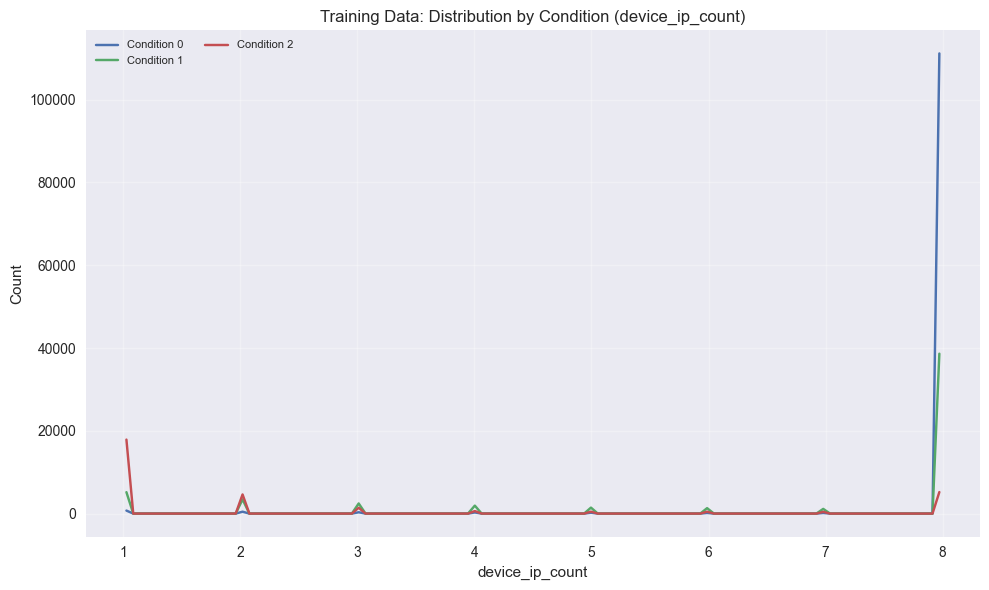

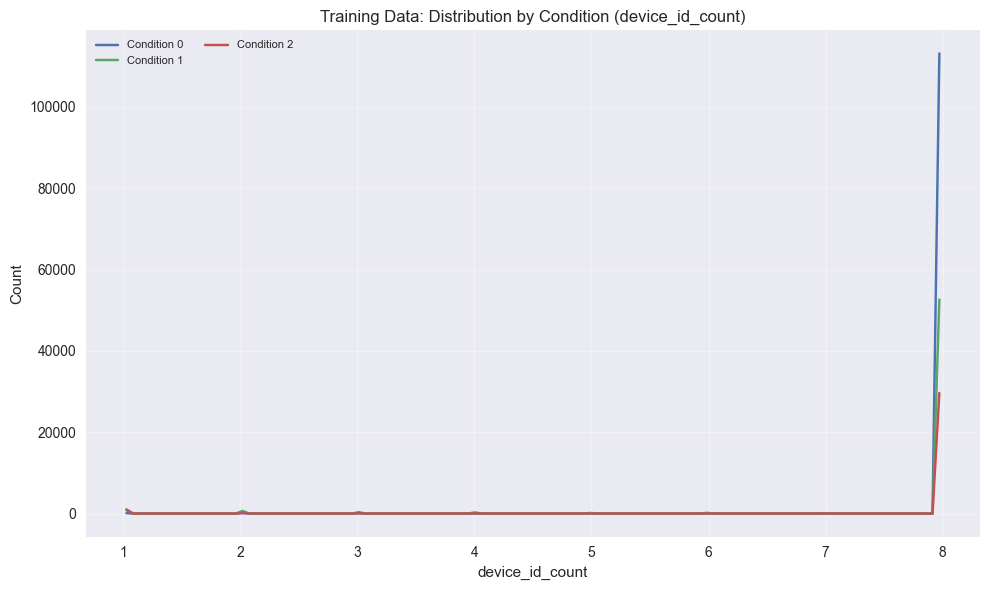

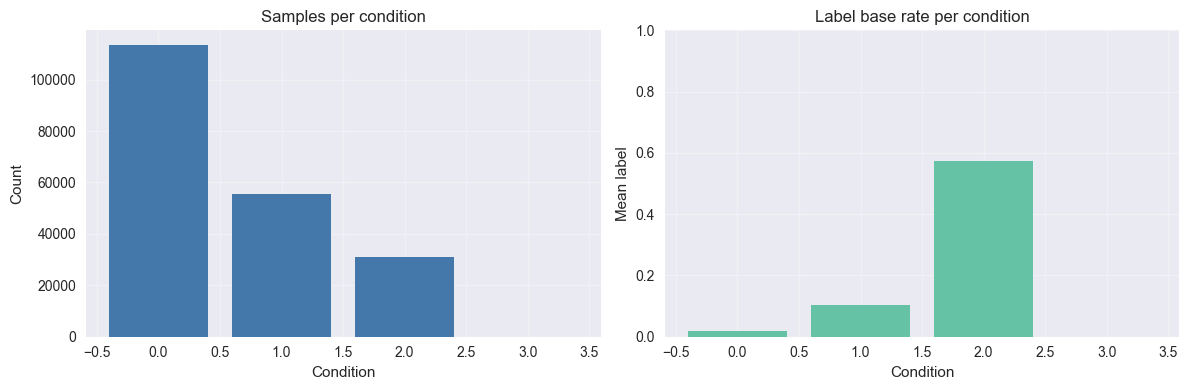

In [3]:
data_bundle = prepare_data(cfg, device, use_cuda)
splits = data_bundle.splits
loaders = data_bundle.loaders
plots_cfg = cfg['plots']
train_cfg = cfg['training']
data_source = get_data_source(cfg)
condition_label = get_condition_label(cfg)

raw_eval_value_range = plots_cfg.get('eval_pred_value_range', [-12, 0])
if isinstance(raw_eval_value_range, (list, tuple)) and len(raw_eval_value_range) == 2:
    eval_value_range = tuple(raw_eval_value_range)
else:
    print("[WARN] plots.eval_pred_value_range should be a 2-item list; using default (-12, 0).")
    eval_value_range = (-12, 0)

# Configure evaluation target via configs/default.json -> evaluation.split.
eval_cfg = cfg.get('evaluation', {})
eval_split = str(eval_cfg.get('split', 'eval')).lower().strip()
valid_eval_splits = {'train', 'eval', 'test'}
if eval_split not in valid_eval_splits:
    print(f"[WARN] Unknown evaluation split '{eval_split}'; defaulting to 'eval'.")
    eval_split = 'eval'

test_labels_available = False
if data_source == 'ctr':
    test_labels_available = bool(cfg.get('ctr', {}).get('test_has_labels', False))


def resolve_eval_bundle(split: str):
    if split == 'train':
        return 'train', loaders.train_loader, splits.y_train, splits.c_train, 'Train'
    if split == 'test':
        if loaders.test_loader is None:
            print("[WARN] Test loader unavailable; falling back to eval split.")
            return 'eval', loaders.eval_loader, splits.y_eval, splits.c_eval, 'Eval'
        # Set evaluation.use_test_labels=true if test contains labels.
        use_test_labels = bool(eval_cfg.get('use_test_labels', False))
        if use_test_labels and not test_labels_available:
            print("[WARN] evaluation.use_test_labels enabled but test labels are unavailable; disabling.")
            use_test_labels = False
        labels = splits.y_test if use_test_labels else None
        if not use_test_labels:
            print("[INFO] Test labels are disabled; skipping label-based metrics.")
        return 'test', loaders.test_loader, labels, splits.c_test, 'Test'
    return 'eval', loaders.eval_loader, splits.y_eval, splits.c_eval, 'Eval'


eval_split, eval_loader, eval_labels, eval_conds, eval_name = resolve_eval_bundle(eval_split)
eval_has_labels = eval_labels is not None

train_eval_loader = loaders.eval_loader
train_eval_conds = splits.c_eval
train_eval_name = 'Eval'

if eval_split == 'train':
    train_eval_loader = loaders.train_loader
    train_eval_conds = splits.c_train
    train_eval_name = 'Train'
elif eval_split == 'test':
    if eval_has_labels:
        train_eval_loader = eval_loader
        train_eval_conds = eval_conds
        train_eval_name = eval_name
    else:
        print("[INFO] Training eval uses Eval split; test labels unavailable.")

if cfg.get('logging', {}).get('print_eval_split', True):
    print(f"Evaluation split: {eval_name}")
    if train_eval_name != eval_name:
        print(f"Training eval split: {train_eval_name}")

if cfg.get('logging', {}).get('print_loader_note', True):
    print(loaders.loader_note)

if data_source == 'ctr' and cfg.get('ctr', {}).get('plot_filter_stats', False):
    ctr_stats = data_bundle.plot_data.get('ctr_stats')
    if ctr_stats:
        plot_ctr_filter_stats(ctr_stats['stats_df'], ctr_stats['labels'], ctr_stats['filter_col'])

if plots_cfg.get('data_before_training', False):
    synth = data_bundle.plot_data.get('synthetic')
    if synth:
        plot_training_distributions(
            synth['net_worth'],
            synth['ages'],
            synth['probs'],
            synth['conds'],
            synth['num_conditions'],
        )
    else:
        if plots_cfg.get('ctr_data_distributions', True):
            ctr_plot = data_bundle.plot_data.get('ctr_distributions')
            if ctr_plot:
                
                print("DEBUG")
                print(ctr_plot['feature_names'])
                print(ctr_plot['num_conditions'])
                log10_features = set(plots_cfg.get('ctr_log10_features', []))
                plot_feature_distributions_by_condition(
                    ctr_plot['xnum'],
                    ctr_plot['conds'],
                    ctr_plot['feature_names'],
                    ctr_plot['num_conditions'],
                    max_features=int(plots_cfg.get('ctr_max_features', 3)),
                    log10_features=log10_features,
                    density=bool(plots_cfg.get('ctr_use_density', False)),
                )
                if plots_cfg.get('ctr_label_rates', True):
                    plot_label_rates_by_condition(
                        ctr_plot['labels'],
                        ctr_plot['conds'],
                        ctr_plot['num_conditions'],
                    )
            else:
                print('CTR plot_sample_size is disabled or empty; skipping CTR distributions.')
        else:
            print('CTR distribution plots are disabled in config.')
else:
    print('Skipping training data distribution plots before training.')



In [4]:
# Diagnostics: input/label/condition stats
from localized_entropy.analysis import (
    print_condition_stats,
    print_feature_stats,
    print_label_stats,
)

print('Diagnostics: splits')
print_feature_stats('Train features', splits.x_train)
print_feature_stats('Eval features', splits.x_eval)
if splits.x_test is not None:
    print_feature_stats('Test features', splits.x_test)

print_condition_stats('Train conds', splits.c_train, splits.num_conditions)
print_condition_stats('Eval conds', splits.c_eval, splits.num_conditions)
if splits.c_test is not None:
    print_condition_stats('Test conds', splits.c_test, splits.num_conditions)

print_label_stats('Train labels', splits.y_train, splits.c_train, splits.num_conditions)
print_label_stats('Eval labels', splits.y_eval, splits.c_eval, splits.num_conditions)
if splits.y_test is not None:
    print_label_stats('Test labels', splits.y_test, splits.c_test, splits.num_conditions)


Diagnostics: splits
Train features: shape=(1213649, 2)
  mean: min=-1.98935e-06 max=1.80883e-06 avg=-9.026e-08
  std:  min=0.997296 max=1.00016 avg=0.998726
  std < 1e-8: 0.00%
Eval features: shape=(134850, 2)
  mean: min=-0.00425523 max=-4.45801e-05 avg=-0.00214991
  std:  min=1.0051 max=1.00729 avg=1.0062
  std < 1e-8: 0.00%
Test features: shape=(4577464, 2)
  mean: min=-2.45297 max=-1.09622 avg=-1.7746
  std:  min=0.699135 max=3.1115 avg=1.90532
  std < 1e-8: 0.00%
Train conds: n=1,213,649 unique=3 min=0 max=2
  counts: min=0 max=688793 mean=303412.25 zeros=1
Eval conds: n=134,850 unique=3 min=0 max=2
  counts: min=0 max=76299 mean=33712.50 zeros=1
Test conds: n=4,577,464 unique=3 min=0 max=3
  counts: min=0 max=4540159 mean=1144366.00 zeros=1
Train labels: n=1,213,649 base_rate=0.129013 min=0 max=1
  per-cond base_rate: min=0.0196706 max=0.572317 avg=0.232167
Eval labels: n=134,850 base_rate=0.129032 min=0 max=1
  per-cond base_rate: min=0.0196857 max=0.568529 avg=0.230254
Test lab

In [5]:
model_cfg = cfg['model']
num_numeric = splits.x_train.shape[1]
cat_dims = splits.cat_sizes
cat_embed_dim = model_cfg.get('cat_embed_dim', model_cfg['embed_dim'])
model = ConditionProbNet(
    num_conditions=splits.num_conditions,
    num_numeric=num_numeric,
    embed_dim=model_cfg['embed_dim'],
    cat_dims=cat_dims,
    cat_embed_dim=cat_embed_dim,
    hidden_sizes=tuple(model_cfg['hidden_sizes']),
    p_drop=model_cfg['dropout'],
).to(device)
model


ConditionProbNet(
  (embedding): Embedding(4, 16)
  (cat_embeddings): ModuleList(
    (0): Embedding(3, 8)
    (1): Embedding(25, 8)
    (2): Embedding(5, 8)
    (3): Embedding(3, 8)
    (4): Embedding(5, 8)
    (5): Embedding(475, 8)
    (6): Embedding(417, 8)
    (7): Embedding(653, 8)
    (8): Embedding(36, 8)
    (9): Embedding(13, 8)
    (10-11): 2 x Embedding(1000, 8)
    (12-13): 2 x Embedding(3, 8)
    (14-15): 2 x Embedding(4, 8)
    (16): Embedding(5, 8)
    (17): Embedding(26, 8)
    (18): Embedding(4, 8)
    (19): Embedding(8, 8)
    (20): Embedding(169, 8)
  )
  (net): Sequential(
    (0): Linear(in_features=186, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=64

In [6]:
# Diagnostics: initial logits/prob stats (untrained)
try:
    batch = next(iter(train_eval_loader))
except StopIteration:
    batch = None

if batch is None:
    print(f"{train_eval_name} loader empty; skipping init logits diagnostics.")
else:
    x_b, x_cat_b, c_b, y_b, nw_b = batch
    x_b = x_b.to(device, non_blocking=non_blocking)
    x_cat_b = x_cat_b.to(device, non_blocking=non_blocking)
    c_b = c_b.to(device, non_blocking=non_blocking)
    with torch.no_grad():
        logits = model(x_b, x_cat_b, c_b)
        probs = torch.sigmoid(logits)
    logits_np = logits.detach().cpu().numpy().reshape(-1)
    probs_np = probs.detach().cpu().numpy().reshape(-1)
    print(
        f"Init batch logits: n={logits_np.size:,} min={logits_np.min():.6g} max={logits_np.max():.6g} "
        f"mean={logits_np.mean():.6g} std={logits_np.std():.6g}"
    )
    print(
        f"Init batch probs:  n={probs_np.size:,} min={probs_np.min():.6g} max={probs_np.max():.6g} "
        f"mean={probs_np.mean():.6g} std={probs_np.std():.6g}"
    )



Init batch logits: n=25,000 min=0.0109993 max=0.202624 mean=0.102049 std=0.0230474
Init batch probs:  n=25,000 min=0.50275 max=0.550483 mean=0.525487 std=0.00574612


Pre-Training Eval (LE) prediction stats per condition:
  cond 0: n=76299 min=0.520161 max=0.530324 mean=0.525221
  cond 1: n=37319 min=0.520198 max=0.528079 mean=0.524622
  cond 2: n=21232 min=0.518461 max=0.528814 mean=0.523651
  cond 3: n=0
Eval predictions per condition: [76299, 37319, 21232, 0]
Conditions with zero eval samples: [3]


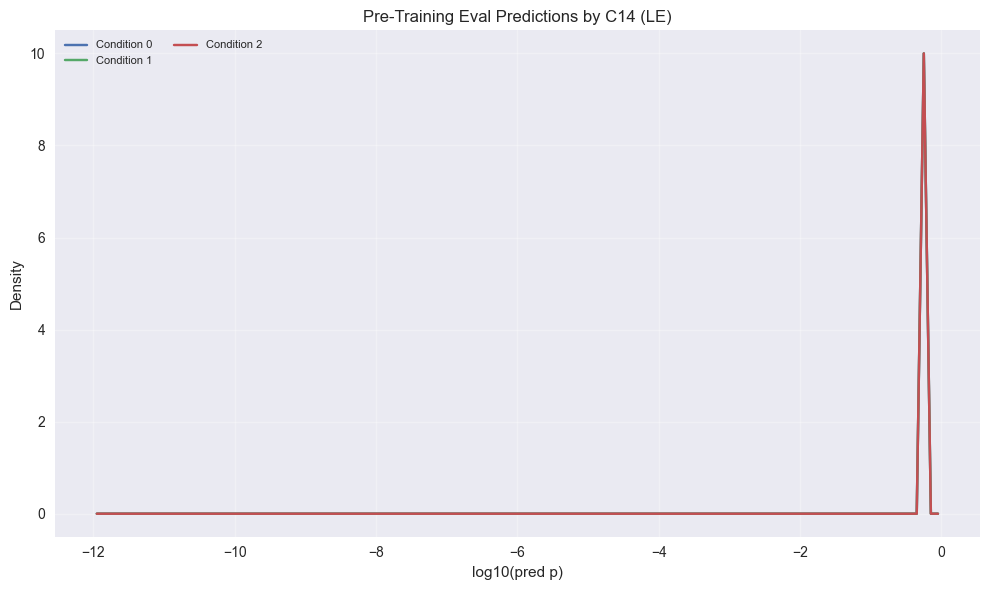

In [7]:
loss_name = loss_label(train_cfg['loss_mode'])
if plots_cfg.get('eval_pred_by_condition', True):
    pretrain_eval_preds = predict_probs(
        model,
        train_eval_loader,
        device,
        non_blocking=non_blocking,
    )
    if pretrain_eval_preds.size > 0:
        if train_eval_conds is None:
            print(f"{train_eval_name} conditions unavailable; skipping per-condition stats.")
        else:
            print_pred_stats_by_condition(
                pretrain_eval_preds,
                train_eval_conds,
                splits.num_conditions,
                name=f"Pre-Training {train_eval_name} ({loss_name})",
            )
            plot_eval_predictions_by_condition(
                pretrain_eval_preds,
                train_eval_conds,
                splits.num_conditions,
                value_range=eval_value_range,
                title=(
                    f"Pre-Training {train_eval_name} Predictions by {condition_label} ("
                    f"{loss_name})"
                ),
            )
    else:
        print(f"{train_eval_name} set is empty after filtering; skipping pre-training plot.")



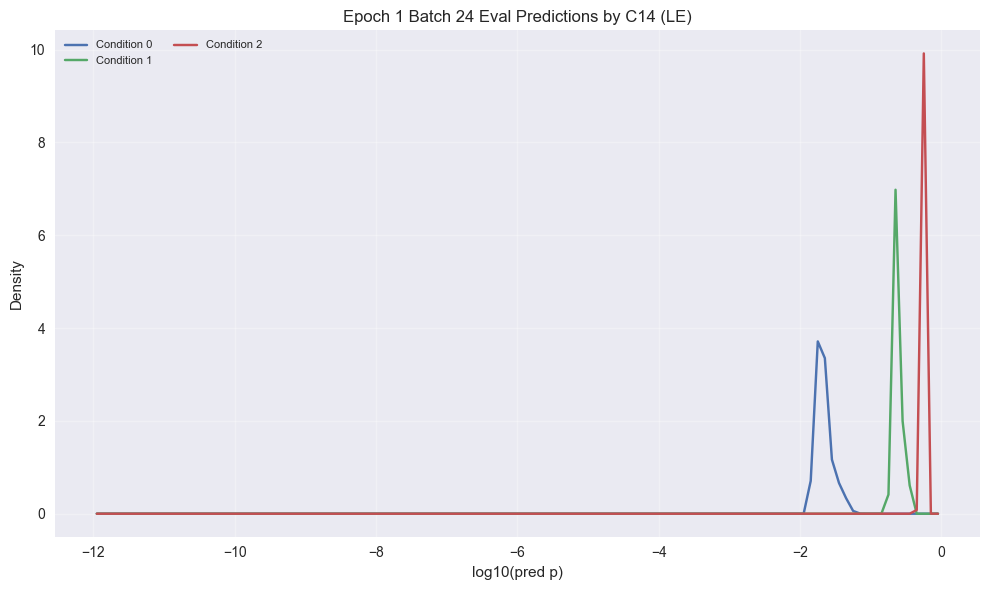

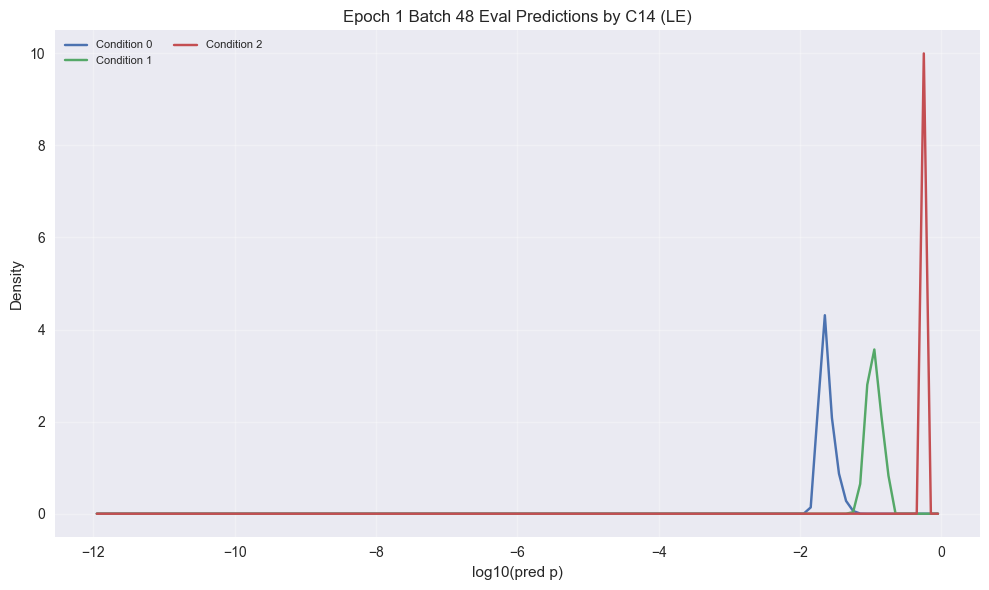

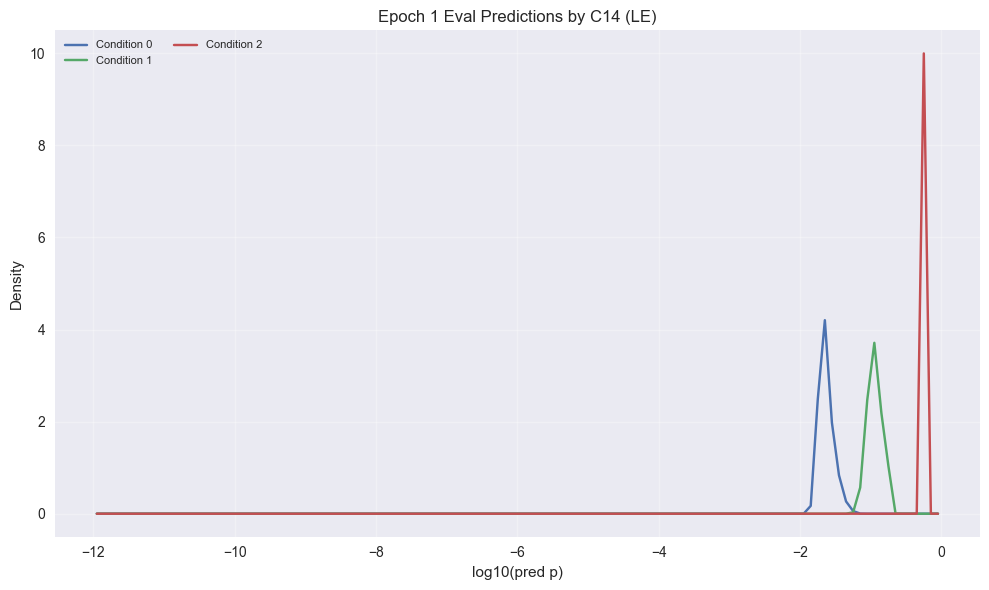

Epoch   1/6 | Train LE: 0.000172 | Eval LE: 0.000132 | wall 18.08s


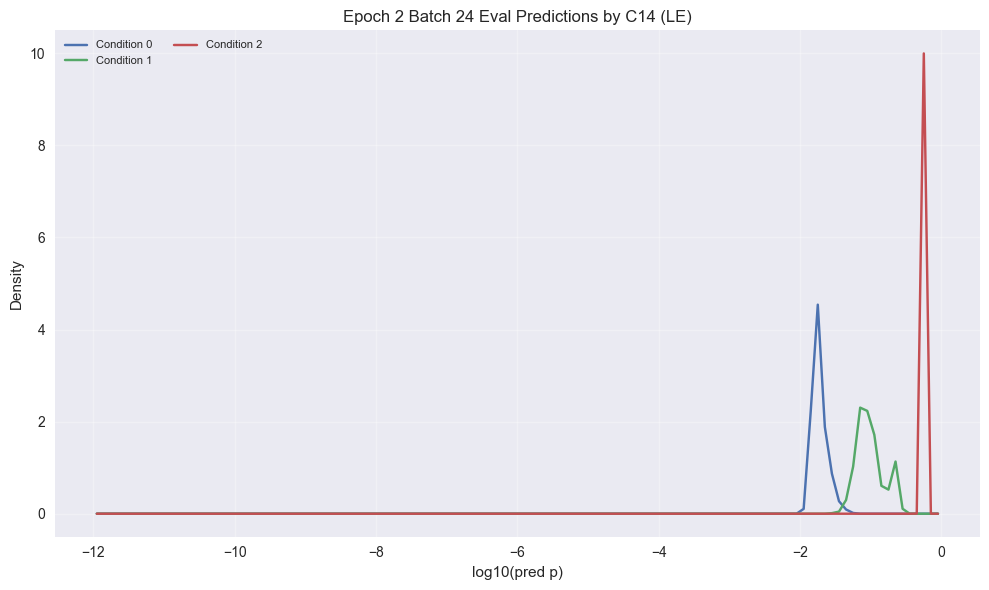

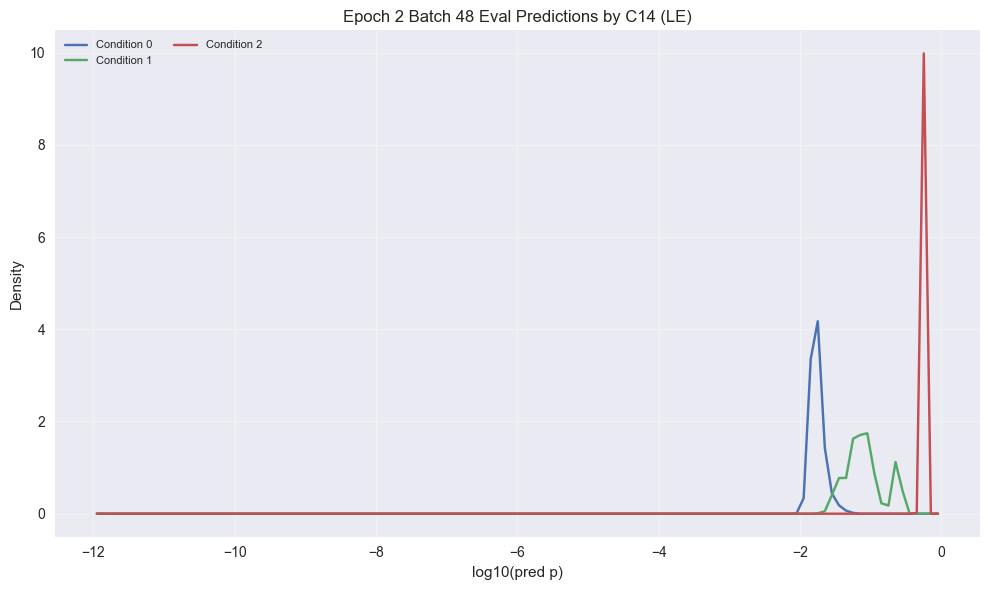

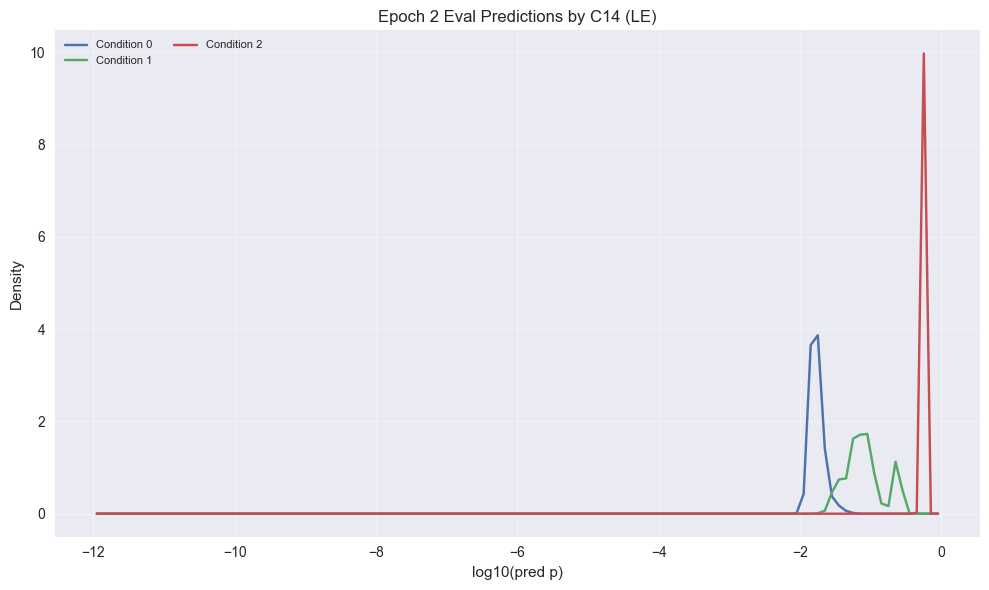

Epoch   2/6 | Train LE: 0.000123 | Eval LE: 0.000130 | wall 18.33s


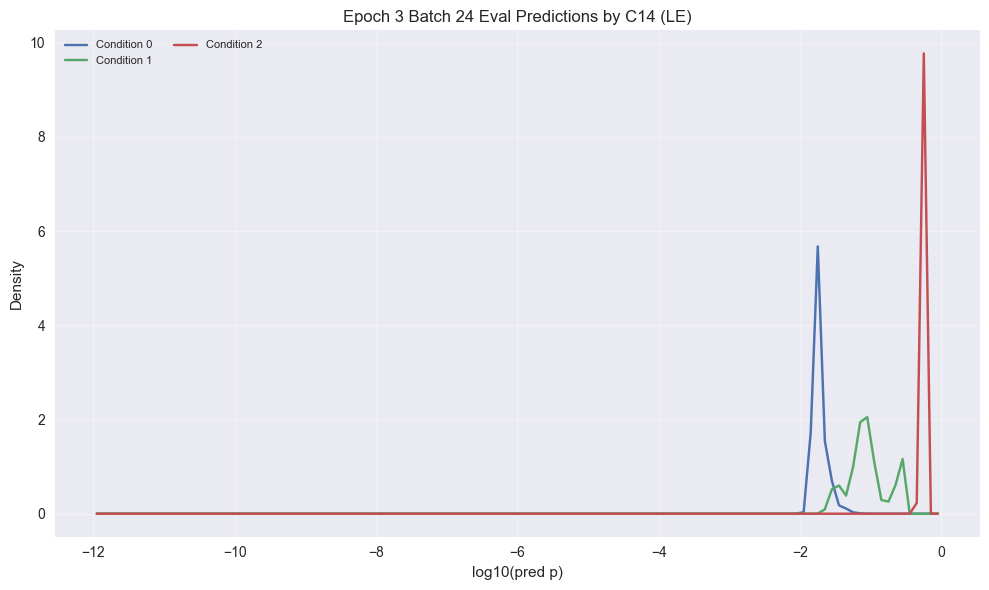

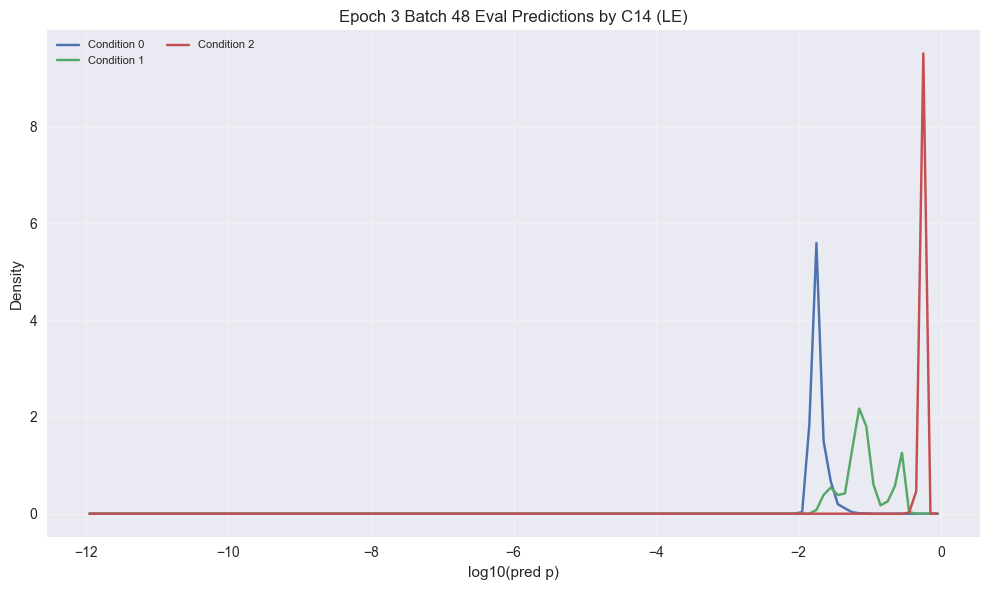

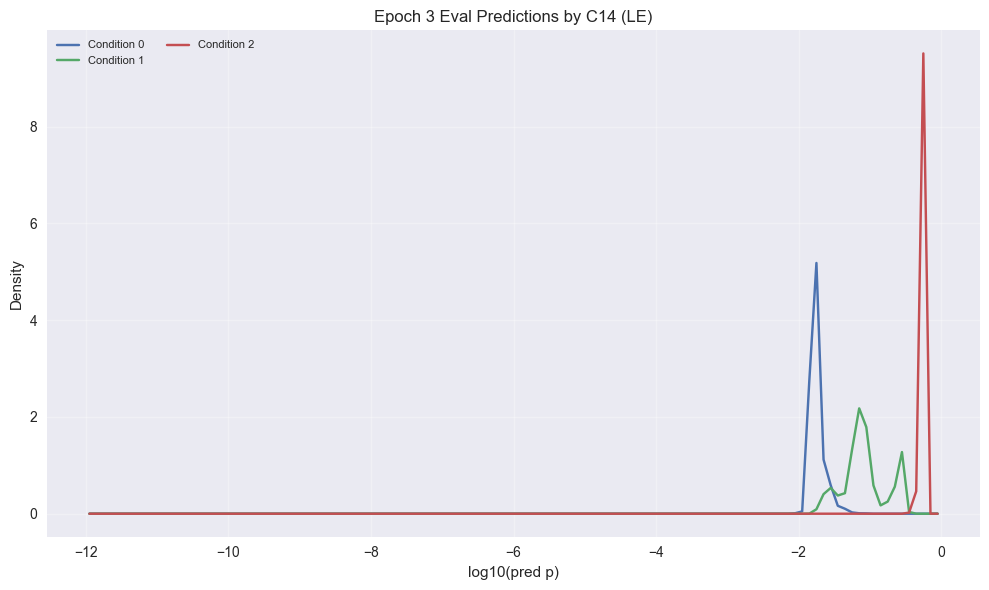

Epoch   3/6 | Train LE: 0.000121 | Eval LE: 0.000129 | wall 18.01s


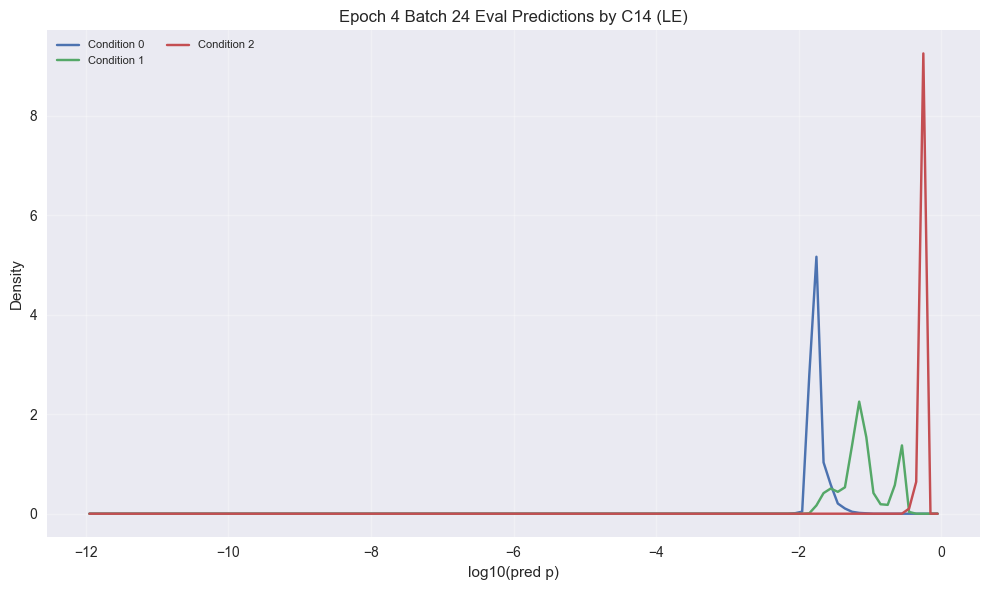

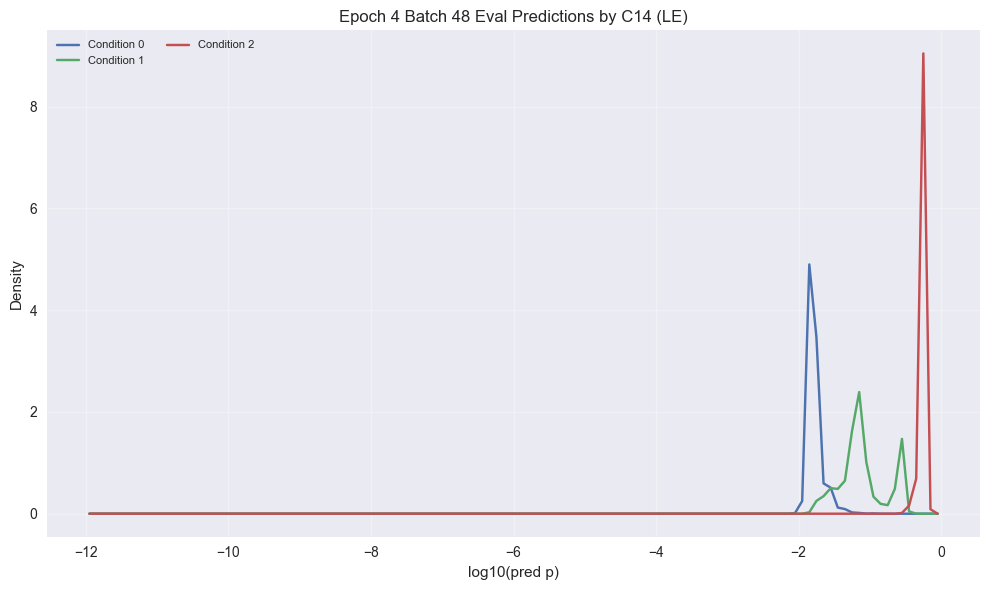

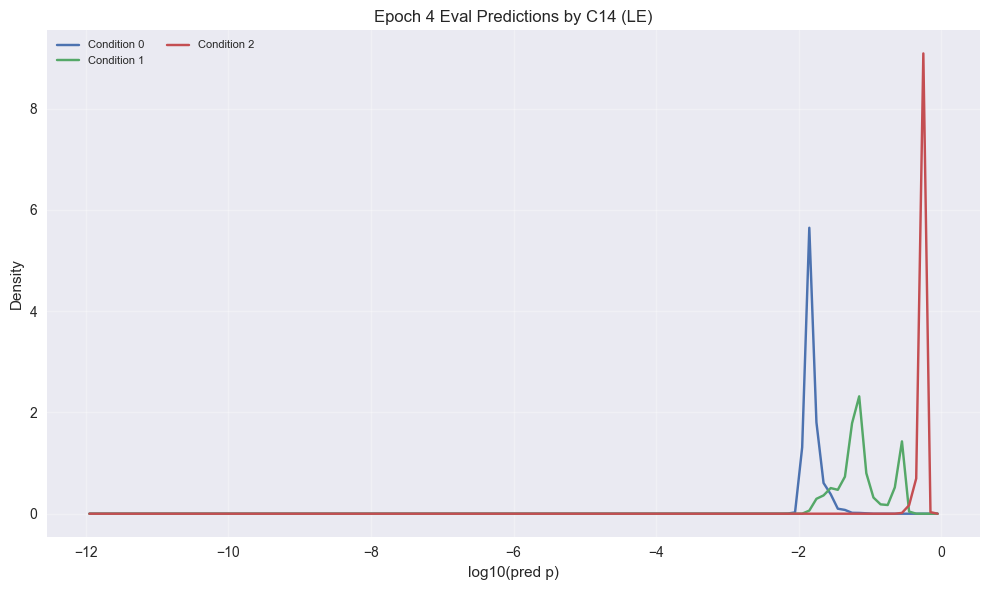

Epoch   4/6 | Train LE: 0.000120 | Eval LE: 0.000128 | wall 18.40s


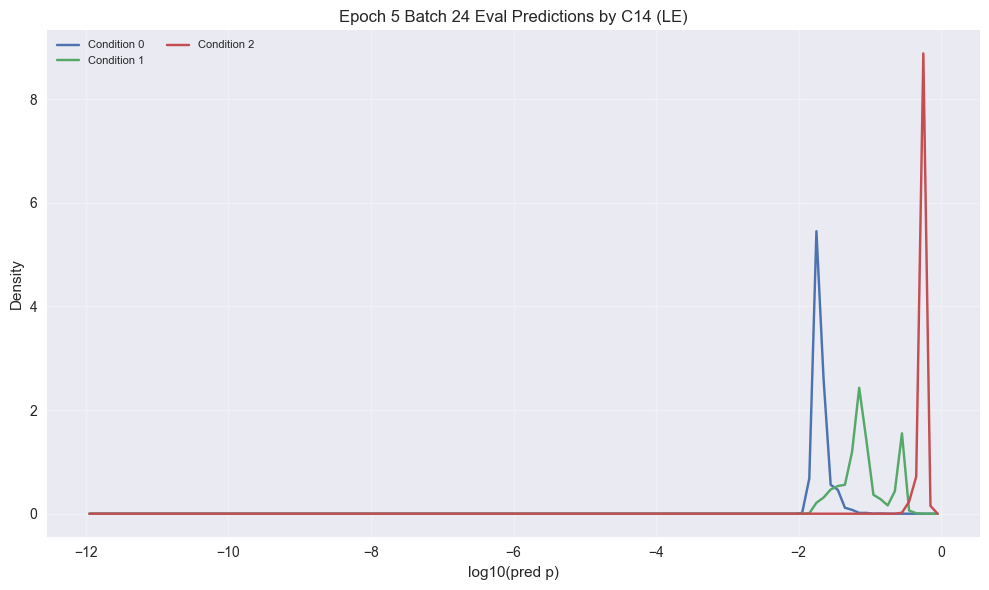

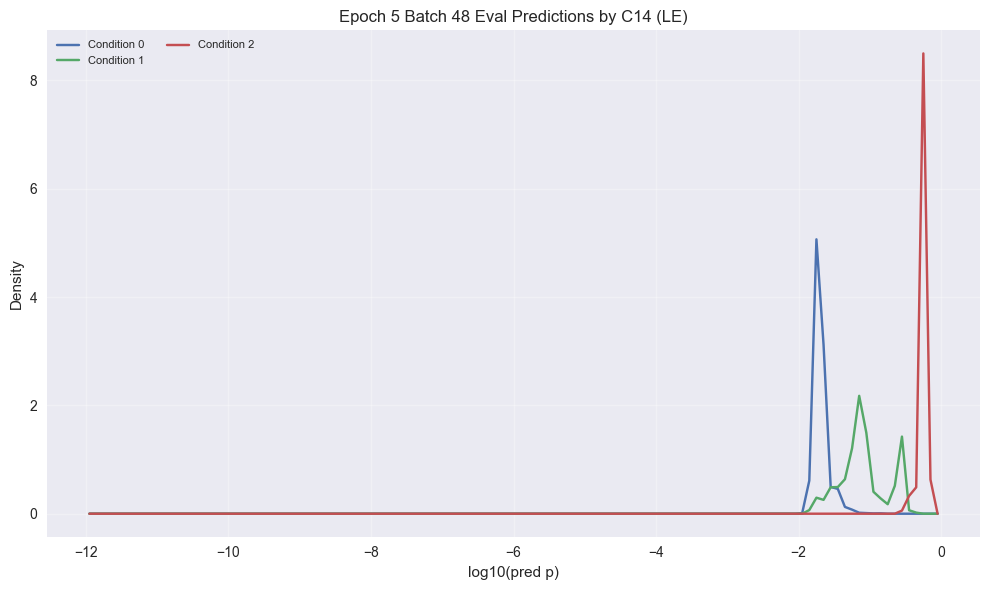

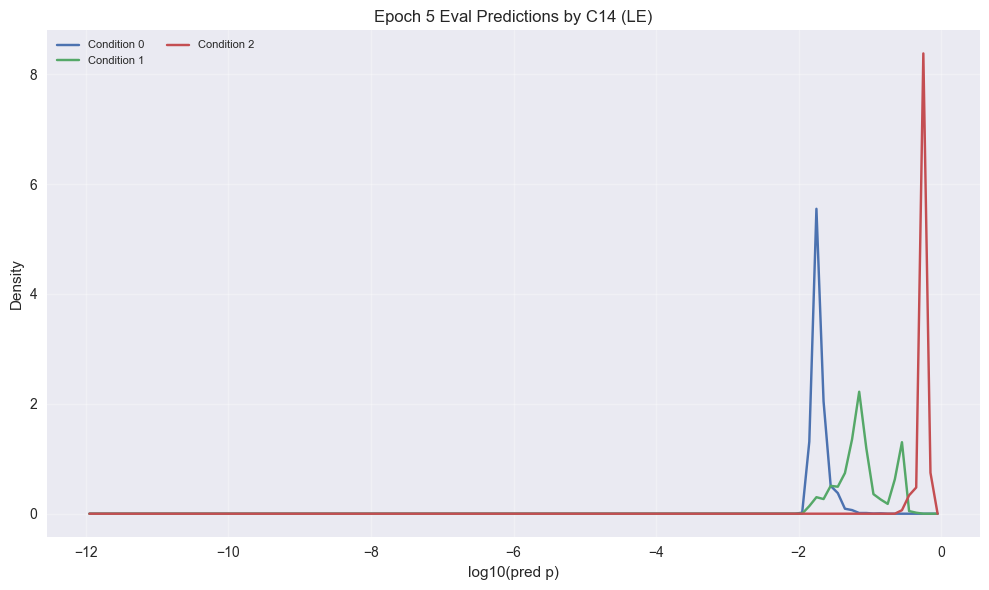

Epoch   5/6 | Train LE: 0.000119 | Eval LE: 0.000127 | wall 18.26s


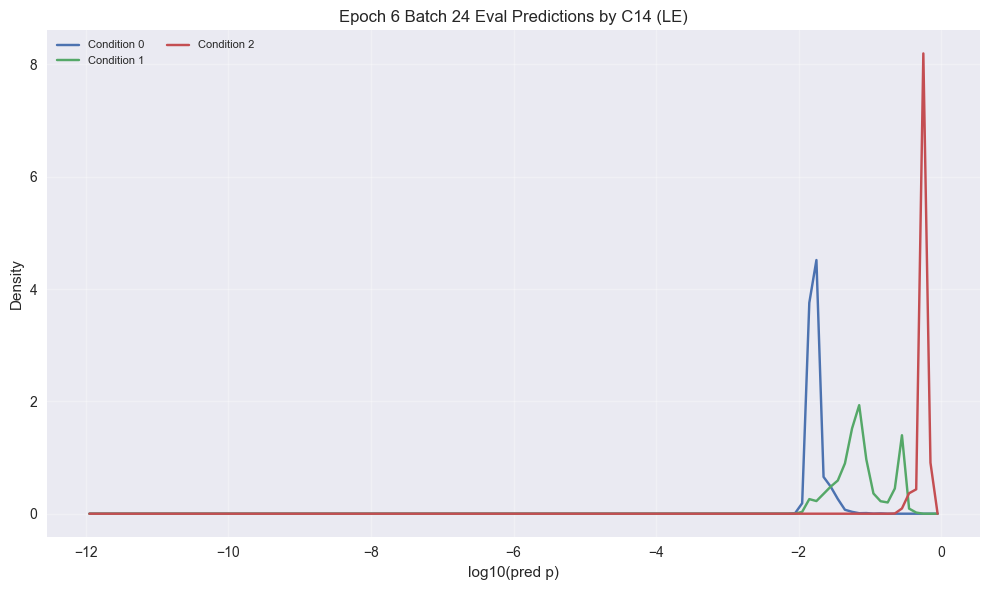

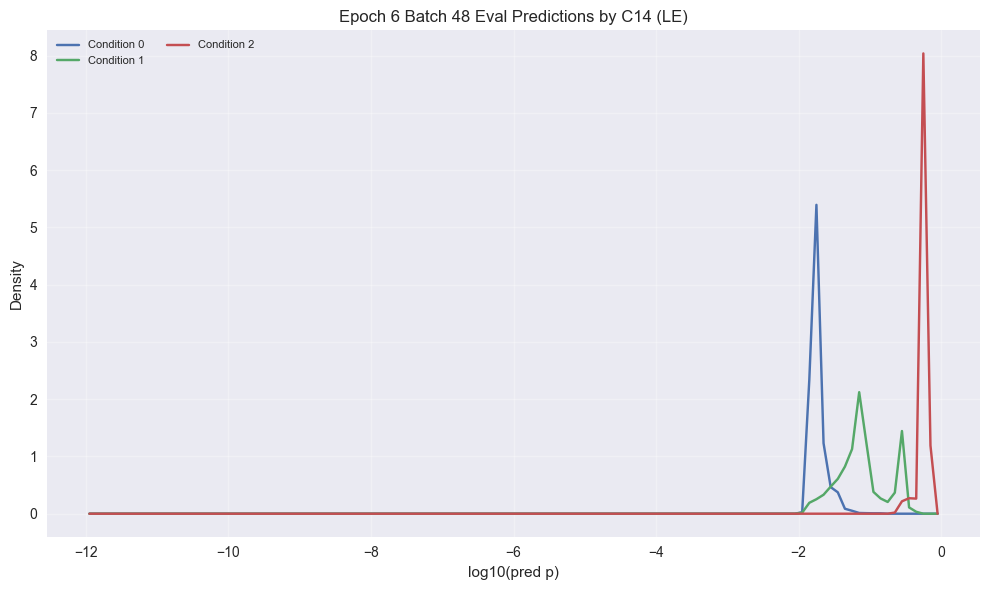

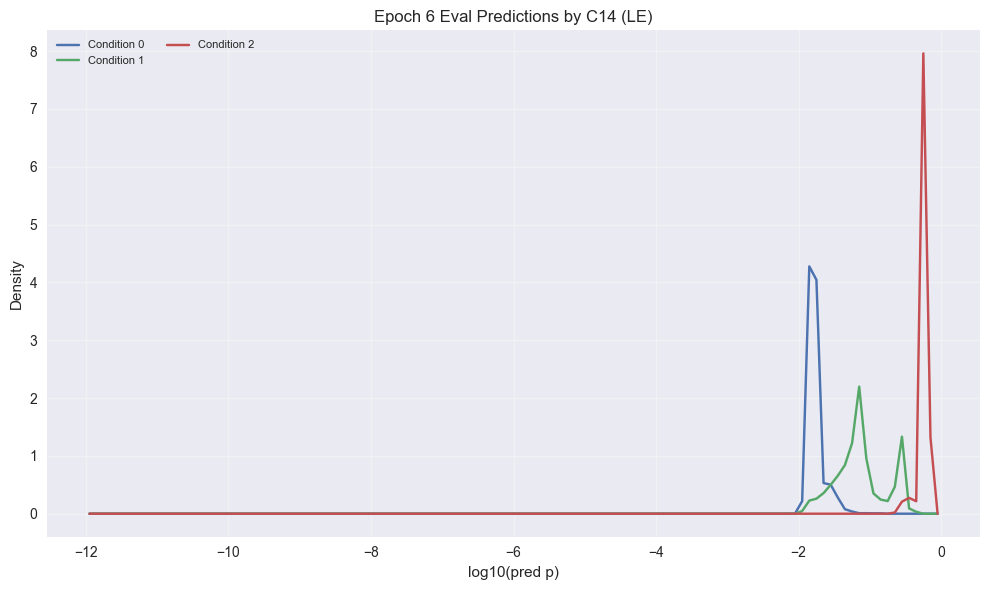

Epoch   6/6 | Train LE: 0.000118 | Eval LE: 0.000127 | wall 18.32s
Final Train LE: 0.0001181873
Final Eval  LE: 0.0001266073


In [8]:
loss_name = loss_label(train_cfg['loss_mode'])


def plot_eval_epoch_preds(preds: np.ndarray, epoch: int) -> None:
    if preds.size == 0:
        print(f"Epoch {epoch}: {train_eval_name} set empty; skipping eval plots.")
        return
    if train_eval_conds is None:
        print(f"Epoch {epoch}: {train_eval_name} conditions unavailable; skipping eval plots.")
        return
    plot_eval_predictions_by_condition(
        preds,
        train_eval_conds,
        splits.num_conditions,
        value_range=eval_value_range,
        title=(
            f"Epoch {epoch} {train_eval_name} Predictions by {condition_label} ("
            f"{loss_name})"
        ),
        print_counts=False,
    )


def plot_eval_batch_preds(preds: np.ndarray, epoch: int, batch_idx: int) -> None:
    if preds.size == 0:
        print(
            f"Epoch {epoch} Batch {batch_idx}: {train_eval_name} set empty; skipping eval plots."
        )
        return
    if train_eval_conds is None:
        print(
            f"Epoch {epoch} Batch {batch_idx}: {train_eval_name} conditions unavailable; skipping eval plots."
        )
        return
    plot_eval_predictions_by_condition(
        preds,
        train_eval_conds,
        splits.num_conditions,
        value_range=eval_value_range,
        title=(
            f"Epoch {epoch} Batch {batch_idx} {train_eval_name} Predictions by {condition_label} ("
            f"{loss_name})"
        ),
        print_counts=False,
    )


plot_eval_epochs = plots_cfg.get('eval_pred_by_condition', True)
eval_every_n_batches = int(train_cfg.get('eval_every_n_batches', 0) or 0)
plot_eval_batches = plot_eval_epochs and eval_every_n_batches > 0

train_losses, eval_losses = train_with_epoch_plots(
    model=model,
    train_loader=loaders.train_loader,
    val_loader=train_eval_loader,
    device=device,
    epochs=train_cfg['epochs'],
    lr=train_cfg['lr'],
    non_blocking=non_blocking,
    plot_eval_hist_epochs=plots_cfg.get('eval_hist_epochs', False),
    loss_mode=train_cfg['loss_mode'],
    eval_callback=plot_eval_epoch_preds if plot_eval_epochs else None,
    eval_every_n_batches=eval_every_n_batches if plot_eval_batches else None,
    eval_batch_callback=plot_eval_batch_preds if plot_eval_batches else None,
)



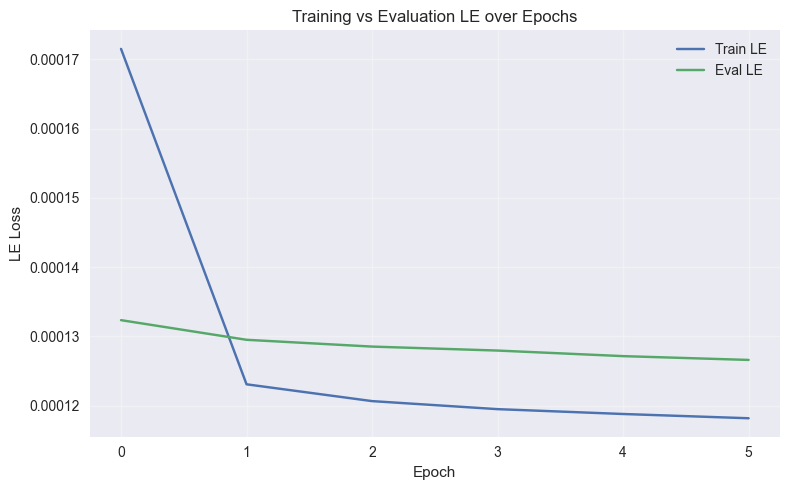

In [9]:
label = loss_label(train_cfg['loss_mode'])
if plots_cfg.get('loss_curves', True):
    plot_loss_curves(train_losses, eval_losses, label)


Eval prediction summary:
  n=134,850 mean=0.129574 std=0.204351
  min=0.008222 p01=0.012394 p05=0.013652 p50=0.020014 p95=0.603566 p99=0.646483 max=0.757501
  label base_rate=0.129032 | logloss=0.239815 | brier=0.071276 | acc@0.5=0.897026
  Top 8 conditions by count:
      count  pred_mean  label_mean
cond                              
0     76299   0.018019    0.019686
1     37319   0.103138    0.102548
2     21232   0.576920    0.568529


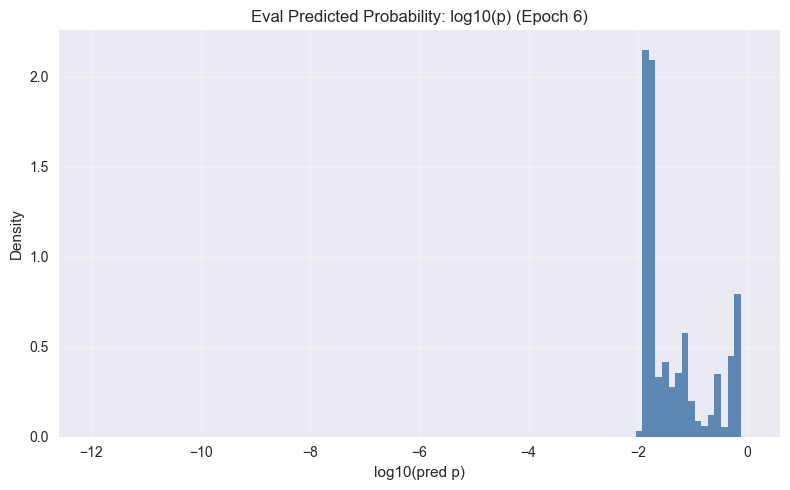

Eval predictions per condition: [76299, 37319, 21232, 0]
Conditions with zero eval samples: [3]


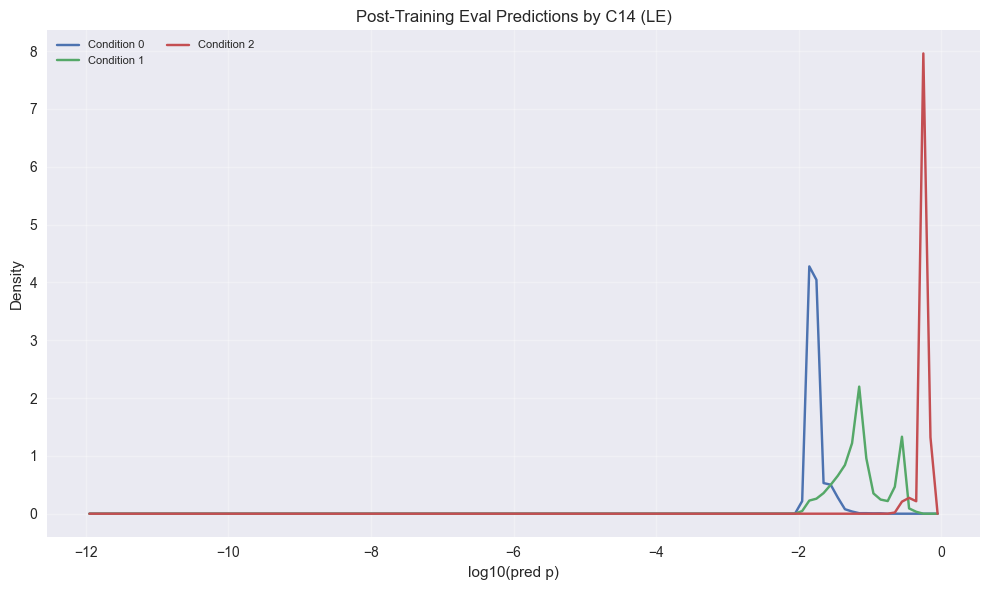

PREDICTIONS ARRAY
[0.0143 0.2952 0.0193 0.0169 0.0964 0.0192 0.0161 0.0187 0.0876 0.0137
 0.1099 0.0144 0.2177 0.0163 0.0128 0.2572 0.0605 0.0153 0.5752 0.0741
 0.0268 0.0213 0.2736 0.0172 0.0351 0.0143 0.0177 0.5809 0.2806 0.0185
 0.0164 0.2667 0.5799 0.2781 0.5385 0.0489 0.0184 0.0166 0.0226 0.0404
 0.0148 0.0765 0.5966 0.0118 0.0155 0.0156 0.0158 0.5919 0.0291 0.0788
 0.7378 0.016  0.0143 0.5387 0.5603 0.0806 0.02   0.019  0.0647 0.0155
 0.0173 0.0348 0.0551 0.6066 0.0155 0.611  0.0914 0.0159 0.0176 0.0147
 0.0205 0.0158 0.1912 0.146  0.0174 0.0185 0.0161 0.0543 0.0187 0.0311
 0.015  0.0145 0.5466 0.0122 0.3017 0.0122 0.5187 0.0174 0.0277 0.0153
 0.575  0.0193 0.0127 0.0132 0.0125 0.0168 0.5953 0.066  0.0195 0.1128]
Final Eval LE: 0.0001266073
Total BCE (log loss): 0.23981549
Total ECE: 0.00405811
Total ECE (small p<= 0.01): 0.04039205
Total ROC-AUC: 0.89078670
Total PR-AUC (AP): 0.56662633
 condition  count  base_rate      bce      ece  ece_small
         0  76299   0.019686 0.0953

In [10]:
if eval_has_labels:
    eval_loss, eval_preds = evaluate(
        model,
        eval_loader,
        device,
        loss_mode=train_cfg['loss_mode'],
        non_blocking=non_blocking,
    )
else:
    eval_preds = predict_probs(
        model,
        eval_loader,
        device,
        non_blocking=non_blocking,
    )
    eval_loss = float('nan')

if plots_cfg.get('print_eval_summary', True):
    print_pred_summary(eval_name, eval_preds, labels=eval_labels, conds=eval_conds)

if plots_cfg.get('eval_pred_hist', True):
    plot_eval_log10p_hist(eval_preds.astype(np.float32), epoch=train_cfg['epochs'])

if plots_cfg.get('eval_pred_by_condition', True):
    if eval_conds is None:
        print(f"{eval_name} conditions unavailable; skipping eval predictions by condition.")
    else:
        plot_eval_predictions_by_condition(
            eval_preds,
            eval_conds,
            splits.num_conditions,
            value_range=eval_value_range,
            title=(
                f"Post-Training {eval_name} Predictions by {condition_label} ("
                f"{label})"
            ),
        )
        print("PREDICTIONS ARRAY")
        print(eval_preds[:100])

if eval_has_labels:
    print(f"Final {eval_name} {label}: {eval_loss:.10f}")
else:
    print(f"Final {eval_name} {label}: n/a (labels unavailable)")

if eval_has_labels:
    eval_cfg = cfg.get('evaluation', {})
    bins = int(eval_cfg.get('ece_bins', 20))
    min_count = int(eval_cfg.get('ece_min_count', 1))
    small_prob_max_cfg = float(eval_cfg.get('small_prob_max', 0.01))
    small_prob_quantile = float(eval_cfg.get('small_prob_quantile', 0.1))

    total_bce = bce_log_loss(eval_preds, eval_labels)
    total_ece, total_ece_table = expected_calibration_error(
        eval_preds, eval_labels, bins=bins, min_count=min_count
    )
    small_threshold = small_prob_max_cfg
    small_mask = eval_preds <= small_threshold
    if not small_mask.any():
        quantile_threshold = float(np.quantile(eval_preds, small_prob_quantile))
        print(
            f"[INFO] No preds <= {small_threshold:g}; using {small_prob_quantile:.2f} quantile "
            f"threshold {quantile_threshold:g} for small-prob calibration."
        )
        small_threshold = quantile_threshold
        small_mask = eval_preds <= small_threshold

    if small_mask.any():
        total_ece_small, _ = expected_calibration_error(
            eval_preds[small_mask],
            eval_labels[small_mask],
            bins=bins,
            min_count=min_count,
        )
    else:
        total_ece_small = float('nan')

    print(f"Total BCE (log loss): {total_bce:.8f}")
    print(f"Total ECE: {total_ece:.8f}")
    print(f"Total ECE (small p<= {small_threshold:g}): {total_ece_small:.8f}")
    total_auc = roc_auc_score(eval_preds, eval_labels)
    total_pr_auc = pr_auc_score(eval_preds, eval_labels)
    print(f"Total ROC-AUC: {total_auc:.8f}")
    print(f"Total PR-AUC (AP): {total_pr_auc:.8f}")

    if eval_cfg.get('print_calibration_table', False):
        print(total_ece_table.to_string(index=False))

    if eval_conds is None:
        print(f"[WARN] {eval_name} conditions unavailable; skipping per-condition metrics.")
    else:
        per_ad = per_condition_metrics(
            eval_preds,
            eval_labels,
            eval_conds,
            bins=bins,
            min_count=min_count,
            small_prob_max=small_threshold,
        )
        if eval_cfg.get('print_per_ad', True):
            top_k = int(eval_cfg.get('per_ad_top_k', 10))
            print(per_ad.head(top_k).to_string(index=False))

    for mode in train_cfg.get('eval_compare_losses', []):
        if mode == train_cfg['loss_mode']:
            continue
        other_loss, _ = evaluate(
            model,
            eval_loader,
            device,
            loss_mode=mode,
            non_blocking=non_blocking,
        )
        other_label = loss_label(mode)
        print(f"Final {eval_name} {other_label}: {other_loss:.10f}")



In [11]:
if loaders.test_loader is not None and eval_split != 'test':
    test_preds = predict_probs(
        model,
        loaders.test_loader,
        device,
        non_blocking=non_blocking,
    )
    if test_preds.size > 0:
        if plots_cfg.get('print_eval_summary', True):
            print_pred_summary('Test', test_preds, labels=None, conds=splits.c_test)
    else:
        print('Test set is empty after filtering; skipping summary.')



Test prediction summary:
  n=4,577,464 mean=0.173720 std=0.089266
  min=0.011865 p01=0.050671 p05=0.071946 p50=0.143866 p95=0.332606 p99=0.479532 max=0.679225
  Top 8 conditions by count:
        count  pred_mean
cond                    
3     4540159   0.172240
2       22535   0.573332
0       14770   0.019001


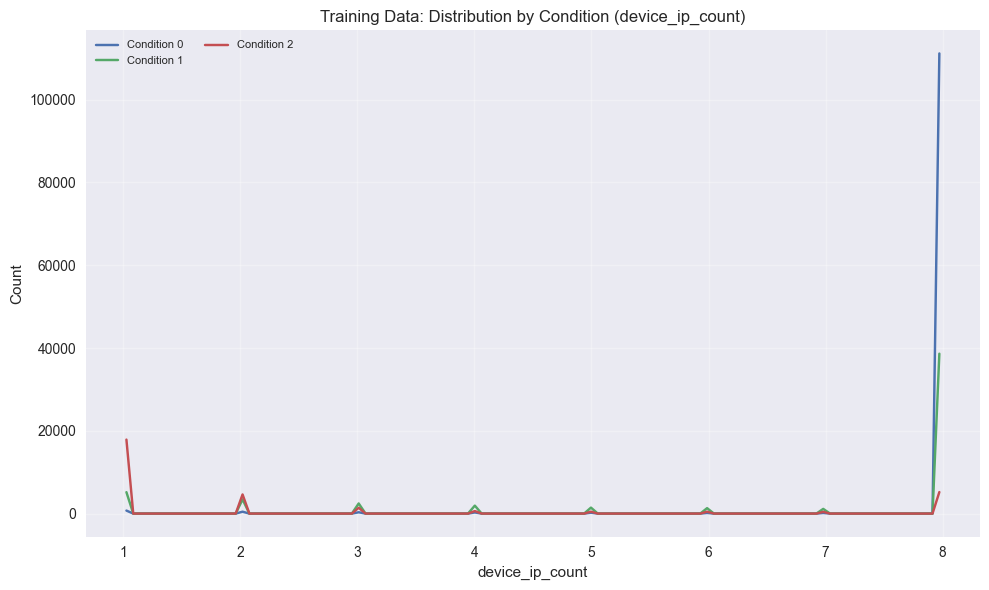

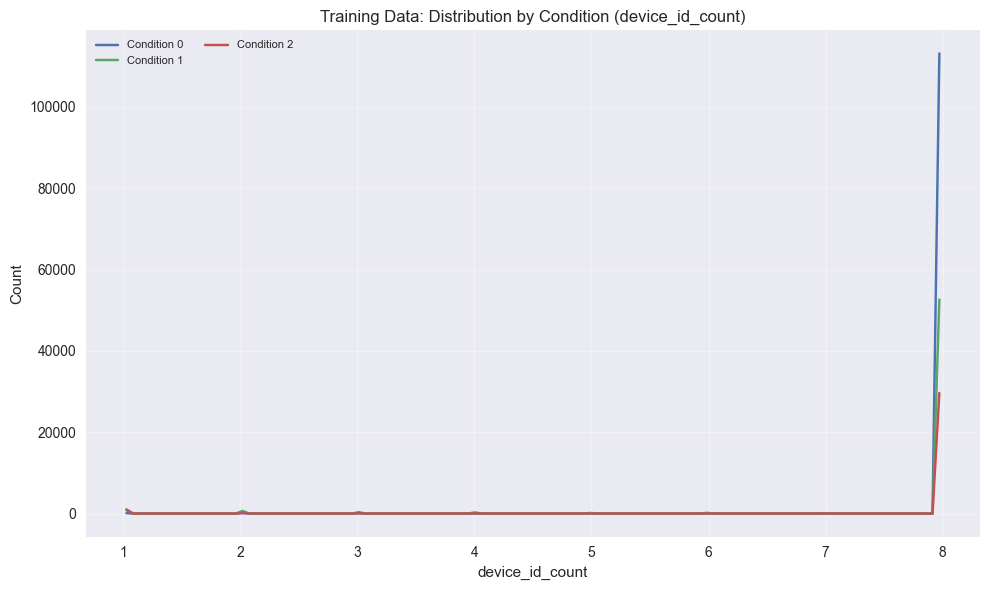

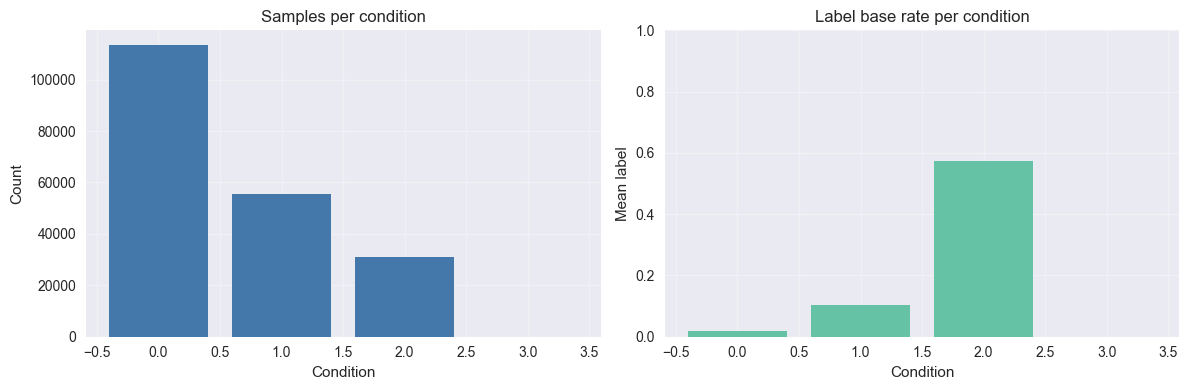

In [12]:
if plots_cfg.get('data_after_training', False):
    synth = data_bundle.plot_data.get('synthetic')
    if synth:
        plot_training_distributions(
            synth['net_worth'],
            synth['ages'],
            synth['probs'],
            synth['conds'],
            synth['num_conditions'],
        )
    else:
        if plots_cfg.get('ctr_data_distributions', True):
            ctr_plot = data_bundle.plot_data.get('ctr_distributions')
            if ctr_plot:
                log10_features = set(plots_cfg.get('ctr_log10_features', []))
                plot_feature_distributions_by_condition(
                    ctr_plot['xnum'],
                    ctr_plot['conds'],
                    ctr_plot['feature_names'],
                    ctr_plot['num_conditions'],
                    max_features=int(plots_cfg.get('ctr_max_features', 3)),
                    log10_features=log10_features,
                    density=bool(plots_cfg.get('ctr_use_density', False)),
                )
                if plots_cfg.get('ctr_label_rates', True):
                    plot_label_rates_by_condition(
                        ctr_plot['labels'],
                        ctr_plot['conds'],
                        ctr_plot['num_conditions'],
                    )
            else:
                print('CTR plot_sample_size is disabled or empty; skipping CTR post-training plots.')
        else:
            print('CTR post-training plots are disabled in config.')
else:
    print('Post-training training data plots are disabled.')


cond	num	den	avg_p	#y=1	#y=0	ratio
0	7275.16	7386.77	0.0196857	1502	74797	0.984891
1	10927.8	12339.4	0.102548	3827	33492	0.885601
2	14136.2	14516.9	0.568529	12071	9161	0.973777


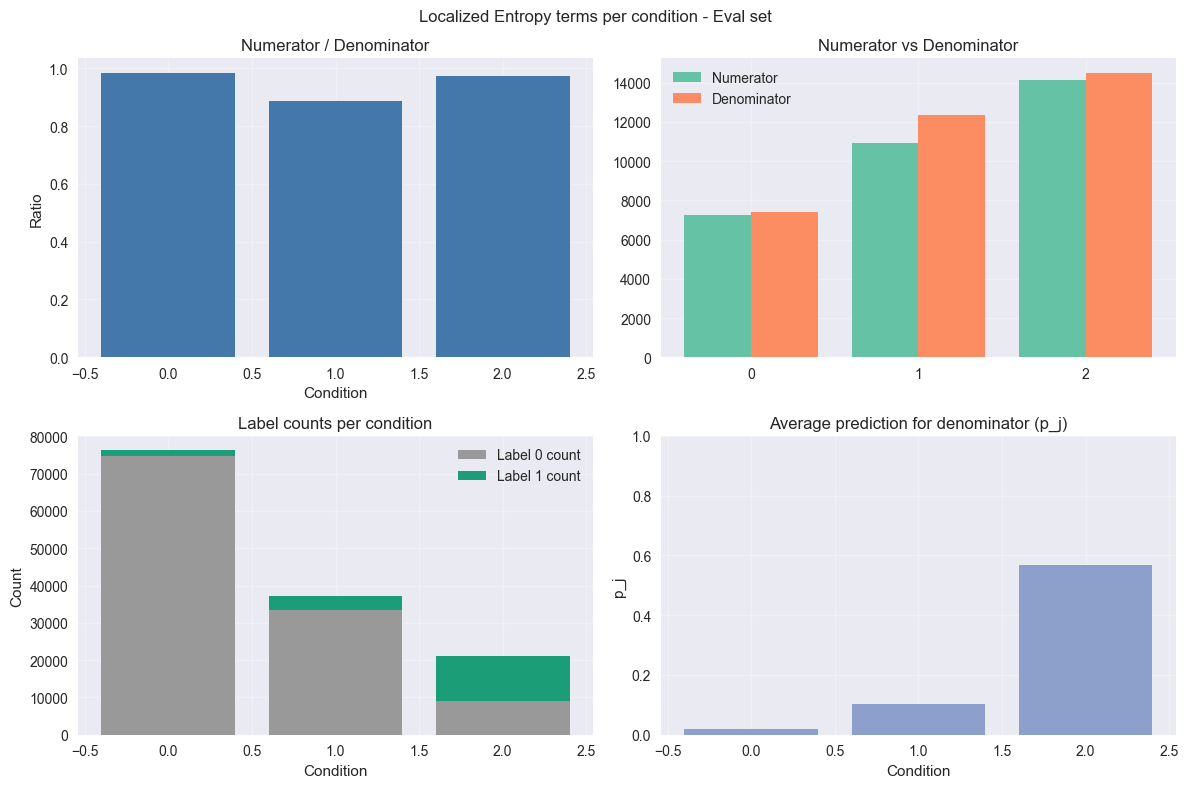

In [13]:
if plots_cfg.get('le_stats', True) or plots_cfg.get('print_le_stats_table', True):
    if not eval_has_labels:
        print(f"{eval_name} labels unavailable; skipping localized entropy stats.")
    elif eval_conds is None:
        print(f"{eval_name} conditions unavailable; skipping localized entropy stats.")
    else:
        z_all, y_all, c_all = collect_logits(model, eval_loader, device, non_blocking=non_blocking)
        le_stats = collect_le_stats_per_condition(z_all, y_all, c_all, eps=1e-12)

        if plots_cfg.get('print_le_stats_table', True):
            print('cond	num	den	avg_p	#y=1	#y=0	ratio')
            for cond in sorted(le_stats.keys()):
                s = le_stats[cond]
                print(
                    f"{cond}	{s['Numerator']:.6g}	{s['Denominator']:.6g}	"
                    f"{s['Average prediction for denominator']:.6g}	"
                    f"{s['Number of samples with label 1']}	"
                    f"{s['Number of samples with label 0']}	"
                    f"{s['Numerator/denominator']:.6g}"
                )

        if plots_cfg.get('le_stats', True):
            plot_le_stats_per_condition(
                le_stats,
                title=f"Localized Entropy terms per condition - {eval_name} set",
            )

